<img src = "https://drive.google.com/uc?export=view&id=1FNyRcLn_ZqLm263UvW1gEDW1_QaTr9hG" alt = "Encabezado MLDS" width = "100%">  </img>

# **Proyecto (Fase 4):** Reconocimiento vocal de ceatáceos 
## **Giovanny Alejandro Cuervo Londoño**

## **Introducción**
---

En esta fase del proyecto, nos enfocaremos en **validar y entrenar** el modelo de reconocimiento vocal de cetáceos marinos. El objetivo principal es diseñar e implementar un modelo de Deep Learning que sea capaz de lograr una mayor precisión en la clasificación de mamíferos marinos utilizando los registros de sus vocalizaciones.

El modelo de Deep Learning será desarrollado utilizando la técnica de **Transfer learning**, una técnica avanzada de aprendizaje profundo. Se utilizará un subconjunto de datos de 5907 vocalizaciones, de la extensa  base de datos [Watkins Marine Mammal Sound Database](https://cis.whoi.edu/science/B/whalesounds/index.cfm), que contiene grabaciones de vocalizaciones de 55 especies de mamíferos marinos.

 Se emplearán técnicas de preprocesamiento de señales de audio, como la reducción de ruido, filtrado y técnicas de aumento de datos (*frequency masking* y *time masking*), para mejorar la calidad y balancear las categorías del conjunto de datos.

Durante la fase de validación, se utilizará la función de perdida **Entropía cruzada categórica dispersa** para el entrenamiento y optimización de parámteros. Se realizarán múltiples etapas de entrenamiento para afinar la eficacia y capacidad de generalización del modelo.

Una vez validado, se procederá a la fase de evaluación del modelo. Se utilizará métricas de evaluación como: *accuracy*, *precision*, *recall* y *f1-score* para evaluar el desempeño real del modelo utilizando un conjunto de datos que nunca ha visto.

El objetivo final de esta fase es lograr un modelo preciso y confiable que pueda identificar vocalizaciones de mamíferos marinos en tiempo real. Esto permitirá avanzar en la investigación y conservación de estas especies.







## Paquetes y carga de datos
---
Instalamos los paquetes necesarios

In [ ]:
# Instalamos algunos paquetes necasarios
!pip install noisereduce
!pip install ipython-autotime
!pip install tensorflow_io
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 380 µs (started: 2023-05-17 00:59:43 +00:00)


Importamos los paquetes

In [ ]:
# Importamos los modulos
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio
# from IPython.display import Audio
import IPython.display as ipd
# Modulos extra
import librosa
import soundfile
import noisereduce as nr
import ast
import IPython.display as ipd
from numpy.random import randint
import scipy.io.wavfile as wav

In [ ]:
# Seleccionamos una semilla para los RNG (Random Number Generator)
tf.random.set_seed(123)
np.random.seed(123)

In [ ]:
print(f'Version de Tensorflow: {tf.__version__}')

Version de Tensorflow: 2.12.0
time: 767 µs (started: 2023-05-17 00:59:52 +00:00)


Conectamos con nuestro drive dond están los adios almacenados

In [ ]:
# Conectamos con nuestro google drive
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 3.3 s (started: 2023-05-17 00:59:52 +00:00)


In [ ]:
# Cargamos nuestro datos a colab descomprimidos
!unzip "/content/drive/MyDrive/Python/Deep learning/Proyecto/best-of-watkins-marine-mammal-sound-database.zip" -d ./content/

Streaming output truncated to the last 5000 lines.
  inflating: ./content/data/PantropicalSpottedDolphin/9400805U.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805V.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805W.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805X.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805Y.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/9400805Z.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008060.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008061.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008062.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008063.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008064.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008065.wav  
  inflating: ./content/data/PantropicalSpottedDolphin/94008066.wav  
  inflating: ./content/data/PantropicalSpottedDolphi

## Funciones necesarias
---
Es necesario definir una serie de funciones para el preprocesamiento y aumentación de los datos.

### Funciones de preprocesamiento
---

In [ ]:
def get_list_path_from_subfolders(dir):
    """
    Crea una lista de rutas para cada uno de los archivos
    dentro de subfolders que estan en un directorio
    """
    # Lista con las rutas de cada archivo
    file_paths = []
    # Iterar sobre los subdirectorios y archivos en dir base
    for subdir, dirs, files in os.walk(dir):
        for file in files:
            # Obtener la ruta completa del archivo
            file_path = os.path.join(subdir, file)
            # Agregar la ruta completa del archivo a la lista file_paths
            file_paths.append(file_path)
    return file_paths   

def get_df_labels_paths(list_paths):
    """
    Crea un df con dos columans
    clases o etiquetas y rutas o paths
    de los archivos de audio
    """
    # Diccionario con keys como columnas y values como datos para definir un df
    data = {'class': [os.path.basename(os.path.dirname(fp)) for fp in list_paths],
            'path': [fp for fp in list_paths]
            }
    # Dataframe a partir del diccionario datos
    return pd.DataFrame(data) 

def get_rand_path(df):
    '''
    Seleccion aleatoria de un ruta con la misma probabilida
    entre las clases
    '''
    labels = df['class']
    # Obtiene las clases y su conteos
    classes, counts = np.unique(labels, return_counts=True)
    # Elige una clase de forma aleatoria
    rand_class = np.random.choice(classes)
    # Agrupa el df por la clase elegida
    df = df.loc[df['class'] == rand_class]
    # Elige una ruta al azar de la clase elegida 
    series_path = np.random.choice(df['path'])
    # Ruta y clase aleatoria
    return series_path, rand_class

def framed_signal(y, sr):
    """
    Retorna una senal segmentada en frames
    """
    # Define la longitud de cada frame en segundos
    f_l = 0.05
    # Define el tamano en pasos del frame y su ventana deslizante
    f_l_samples = int(f_l * sr)
    # Define el tamano de la ventana
    frame_length = f_l_samples
    # Tamano del paso
    hop_length =f_l_samples
    # En el caso de audios muy cortos
    if len(y) < frame_length: # Solver: ParameterError: Input is too short {} for frame_length={}
        frame_length = len(y)
        hop_length = len(y)
    # Halla unos frames que solo se usaran como indices
    frames = librosa.util.frame(np.arange(len(y)), 
                                frame_length = frame_length, 
                                hop_length =hop_length
                              )
    # Define una lista de tuplas
    # Cada tupla es el idx inicial y final de cada frame
    frame_idx = [(i * hop_length+1, 
                      i * hop_length + frame_length) for i in range(frames.shape[1])]
    # Hacemos cortes en la senal para defirnir los frame
    y_framed = [y[frame_idx[i][0]:frame_idx[i][1]] for i in range(len(frame_idx))]
    # Frames a nunpy
    y_framed = np.array(y_framed) 
    # Senal segmentada
    return y_framed

def filtered_signal(y, sr): 
    """
    Retorna una senal sin los frame mudos o los que
    no tienen el sonido caracteristico, por tanto son 
    frames sin informacion
    """
    # Segmenta la senal
    mean_y = y.mean()
    std_y = y.std()
    # Definir umbral
    threshold = mean_y + 1 * std_y
    # Senal segmentada
    y_framed = framed_signal(y, sr)
    # Solo conserva los segmentos con vocalizaciones
    y_filtered = []
    for fram in y_framed:
        if np.max(abs(fram)) >= threshold:
            y_filtered.extend(fram)
    # Senal filtrada
    return np.array(y_filtered)  

def load_wav_16k_mono(filename):
    """ 
    Carga un archivo WAV, lo convierte a un tensor con dtype float, 
    resample a 16 kHz monocanal. 
    """
    # Lee un audio de 8-bit
    fs, audio = wav.read(filename)
    # Convierte el audio a 16-bit formato int
    audio_16bit = (audio.astype('int16') - 128) * 256
    # Guarda el audio de 16-bit
    wav.write(filename, fs, audio_16bit)
    # Decodifica a binatio el archivo
    audio_16bit = tf.io.read_file(filename)
    # Convierte el audio a tensor
    wav_y, sample_rate = tf.audio.decode_wav(
          audio_16bit,
          desired_channels=1)
    # Elimina dimensiones de tamano 1
    wav_y = tf.squeeze(wav_y, axis=-1)
    # Cambia en dtype a int 64
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample de la senal
    wav_y = tfio.audio.resample(wav_y, rate_in=sample_rate, rate_out=16000)
    # Tensor senal y su sample rate
    return wav_y, sample_rate

In [ ]:
# Definimos una serie de funciones para preprocesamiento para Yamnet
def load_wav_for_map(filename, label):
    """
    Wraper para de la funcion:
    * load_wav_16k_mono
    para el tf.data.Dataset.from_tensor_slices
    """
    # Convierte un tensor a numpy
    filename = filename.numpy().decode()
    y, sr = load_wav_16k_mono(filename)
    return y, sr, label

def proproces_for_map(y, sr):#, label):
    """
    Wraper para de la funciones:
    * nr.reduce_noise
    * filtered_signal
    para el tf.data.Dataset.from_tensor_slices
    """
    # Reduccion de ruido
    y, sr = y.numpy(), sr.numpy()
    if sr < 2**13: sr = 2**13 # Solver: freq_mask_smooth_hz needs to be at least {}Hz
    y = nr.reduce_noise(y = y, sr = sr, 
                        n_std_thresh_stationary=1.5, 
                        stationary=True, # True
                        )
    y = filtered_signal(y, sr)
    # Convertir el audio en un tensor TensorFlow
    #audio_tensor = tf.convert_to_tensor(y, dtype=tf.float32)
    return y, sr#audio_tensor, sr, label

# Extrae embedding de los datos para la entrada al modelo
def extract_embedding(wav_data):#, label):
    ''' 
    Extraccion de embeddings de datos tipo wav
    para la YAMNet 
    '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]
    return embeddings #(embeddings, tf.repeat(label, num_embeddings))

### Funciones de pipline dataset
---

In [ ]:
# Salta o descarta los datos que presenten error en load_wav_for_map
# Datos corruptos al pasar de 8 bits a 16 bits
def load_wav_for_map_skipErr(fname): #, label):
    try:
        # Si no hay error aplica la funcion
        # return load_wav_for_map(fname, label)
        return load_wav_16k_mono(pfile)
    except Exception as e:
        print(f'Error en load_wav_for_map_skipErr: {fname}')
        print(f"An error occurred: {e}")
        # Si hay error agrega a la lista la ruta problematica
        wav_Err_load16k.append(fname)
# Salta o descarta los datos que presenten error en proproces_for_map
def proproces_for_map_skipErr(y, sr, fname):#, label):
    try:
        # Si no hay error aplica la funcion
        return proproces_for_map(y, sr)#, label)
    except Exception as e:
        print(f'Error en proproces_for_map_skipErr: {fname}')
        print(f"An error occurred: {e}")
        # Si hay error agrega a la lista la ruta problematica
        wav_Err_preprocess.append(fname)

### Funciones para *Aumentación de datos*
---

In [ ]:
def get_list_path_from_subfolders(dir):
    """
    Crea una lista de rutas para cada uno de los archivos
    dentro de subfolders que estan en un directorio
    """
    # Lista con las rutas de cada archivo
    file_paths = []
    # Iterar sobre los subdirectorios y archivos en dir base
    for subdir, dirs, files in os.walk(dir):
        for file in files:
            # Obtener la ruta completa del archivo
            file_path = os.path.join(subdir, file)
            # Agregar la ruta completa del archivo a la lista file_paths
            if file_path.endswith('.wav'):
                file_paths.append(file_path)
    return file_paths 

def get_df_labels_paths(list_paths):
    """
    Crea un df con dos columans
    clases o etiquetas y rutas o paths
    de los archivos de audio
    """
    # Diccionario con keys como columnas y values como datos para definir un df
    data = {'class': [os.path.basename(os.path.dirname(fp)) for fp in list_paths],
            'path': [fp for fp in list_paths]
            }
    # Dataframe a partir del diccionario datos
    return pd.DataFrame(data)

def get_rand_path(df):
    '''
    Seleccion aleatoria de un ruta con la misma probabilida
    entre las clases
    '''
    labels = df['class']
    # Obtiene las clases y su conteos
    classes, counts = np.unique(labels, return_counts=True)
    # Elige una clase de forma aleatoria
    rand_class = np.random.choice(classes)
    # Agrupa el df por la clase elegida
    df = df.loc[df['class'] == rand_class]
    # Elige una ruta al azar de la clase elegida 
    series_path = np.random.choice(df['path'])
    # Ruta y clase aleatoria
    return series_path, rand_class

def data_augment_freq_time(fpath):
    """
    Aumentacion de datos de audio utilizando:
    * Frequency masking
    * Time masking
    """
    audio = tfio.audio.AudioIOTensor(fpath)
    sr = audio.rate.numpy()
    y_squeeze = tf.squeeze(audio.to_tensor(), axis=[-1])
    y_tensor = tf.cast(y_squeeze, tf.float32) / 32768.0
    spectrogram = tfio.audio.spectrogram(y_tensor, nfft=512, window=512, stride=256)
    # Data aumentation
    freq_mask = tfio.audio.freq_mask(spectrogram, param=15)
    time_mask = tfio.audio.time_mask(freq_mask, param=15)
    time_spec_inver = tfio.audio.inverse_spectrogram(time_mask, nfft=512, window=512, 
                                                     stride=256, iterations=30)
    # Retorna tensor float32
    return time_spec_inver.numpy().tolist()

#### Ejemplo de Aumentación de datos
---


In [ ]:
# audio = tfio.audio.AudioIOTensor(list_path_[10])
audio = tfio.audio.AudioIOTensor("./content/data/GrayWhale/99001008.wav")
# audio = tfio.audio.AudioIOTensor('/content/drive/MyDrive/Python/Deep learning/Proyecto/preproces/GrayWhale/99001008.wav')
sr = audio.rate.numpy()
y_squeeze = tf.squeeze(audio.to_tensor(), axis=[-1])
y_tensor = tf.cast(y_squeeze, tf.float32) / 32768.0
ipd.Audio(y_tensor.numpy(), rate=sr)

time: 26.9 ms (started: 2023-05-16 05:30:51 +00:00)


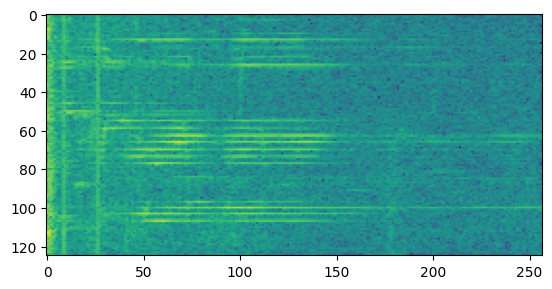

time: 342 ms (started: 2023-05-16 05:35:29 +00:00)


In [ ]:
# Convert to spectrogram
spectrogram = tfio.audio.spectrogram(y_tensor, nfft=512, window=512, stride=256)
plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

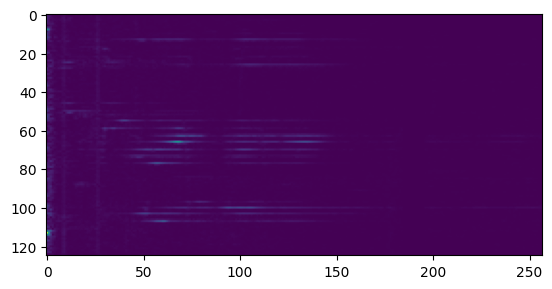

time: 270 ms (started: 2023-05-16 05:35:35 +00:00)


In [ ]:
# Freq masking
freq_mask = tfio.audio.freq_mask(spectrogram, param=15)

plt.figure()
plt.imshow(freq_mask.numpy())

In [ ]:
freq_spec_inver = tfio.audio.inverse_spectrogram(freq_mask, nfft=512, window=512, stride=256, iterations=30)
ipd.Audio(freq_spec_inver.numpy(), rate=sr)

time: 490 ms (started: 2023-05-16 05:35:39 +00:00)


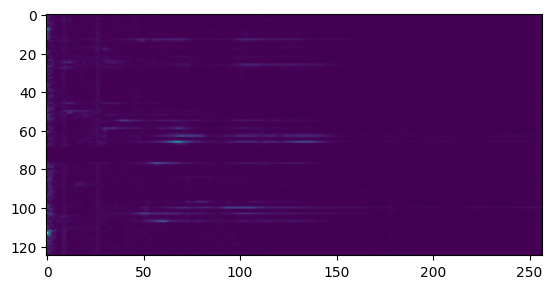

time: 263 ms (started: 2023-05-16 05:39:02 +00:00)


In [ ]:
# Time masking
time_mask = tfio.audio.time_mask(spectrogram, param=15)

plt.figure()
plt.imshow(time_mask.numpy())

In [ ]:
time_spec_inver = tfio.audio.inverse_spectrogram(time_mask, nfft=512, window=512, stride=256, iterations=30)
ipd.Audio(time_spec_inver.numpy(), rate=sr)

time: 1.31 s (started: 2023-05-16 05:36:05 +00:00)


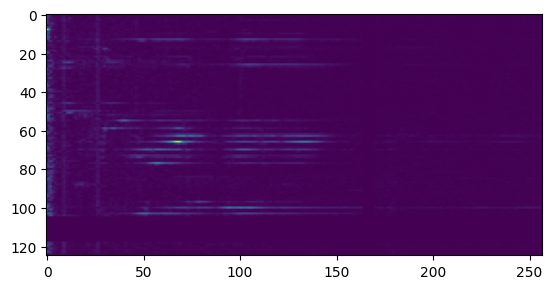

time: 285 ms (started: 2023-05-16 05:40:07 +00:00)


In [ ]:
# Data aumentation: freq masking + time masking
freq_mask = tfio.audio.freq_mask(spectrogram, param=15)
time_mask = tfio.audio.time_mask(freq_mask, param=15)

plt.figure()
plt.imshow(time_mask.numpy())

In [ ]:
time_spec_inver = tfio.audio.inverse_spectrogram(time_mask, nfft=512, window=512, stride=256, iterations=30)
ipd.Audio(time_spec_inver.numpy(), rate=sr)

time: 713 ms (started: 2023-05-16 05:40:23 +00:00)


## Preprocesamiento
---

In [ ]:
dir = '/content/drive/MyDrive/Python/Deep learning/Proyecto/'
df_for_dataset = pd.read_csv(dir+'df_for_dataset.csv')
df_for_dataset

In [ ]:
# Directorio base para guardar los archivos
base_dir = '/content/drive/MyDrive/Python/Deep learning/Proyecto/'
# Directorio para almacenar los archivos preprocesados
dir = 'preproces'
# Lista para almacenar los archivos de audio que presentan errores al cargarse
wav_Err_load16k = []
# Lista para almacenar los archivos de audio preprocesados que presentan errores
wav_Err_preprocess = []
# Itera sobre cada archivo de audio en la columna 'path' del dataframe 'df_for_dataset'
for pfile in df_for_dataset['path']:
    try:
        # Carga el archivo de audio utilizando la función 'load_wav_for_map_skipErr'
        y, sr = load_wav_for_map_skipErr(pfile)
        # Realiza el preprocesamiento del audio utilizando la función 'proproces_for_map_skipErr'
        y, sr = proproces_for_map_skipErr(y, sr, pfile)
        # Obtiene el nombre del directorio del archivo
        dfile = os.path.basename(os.path.dirname(pfile))
        # Si el directorio no existe, se crea
        if not os.path.exists(os.path.join(base_dir, dir, dfile)):
            os.makedirs(os.path.join(base_dir, dir, dfile))
        # Obtiene el nombre del archivo
        fname = os.path.basename(pfile)
        # Genera la nueva ruta para guardar el archivo preprocesado
        new_path = os.path.join(base_dir, dir, dfile, fname)
        # Escribe la salida de audio en un archivo
        soundfile.write(new_path, y, sr)
    except TypeError:
        # Si ocurre un error de tipo, continúa con la siguiente iteración
        continue

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=494
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=519
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=672
  warnings.warn(


Error en load_wav_for_map_skipErr: ./content/data/ClymeneDolphin/8303503L.wav
An error occurred: WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 41600, nBlockAlign = 2, and nAvgBytesPerSec = 62400


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=288
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=424
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=483
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=367
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=421
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=871
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: 

Error en load_wav_for_map_skipErr: ./content/data/ClymeneDolphin/8303503L.wav
An error occurred: WAV header is invalid: nAvgBytesPerSec must equal product of nSamplesPerSec and nBlockAlign, but file has nSamplesPerSec = 41600, nBlockAlign = 2, and nAvgBytesPerSec = 62400


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=1024 is too large for input signal of length=431
  warnings.warn(


time: 36min 50s (started: 2023-05-14 22:59:58 +00:00)


Para generar los embedings es necesario ccaragar el modelo preentrenado

In [ ]:
# Cargamos el modelo preentrenado Yamnet
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
def load_librosa_wraper_y(fpath):
    y, sr = librosa.load(fpath)
    return y
def load_librosa_wraper_sr(fpath):
    y, sr = librosa.load(fpath)
    return sr

time: 735 µs (started: 2023-05-17 01:00:32 +00:00)


In [ ]:
base_dir = '/content/drive/MyDrive/Python/Deep learning/Proyecto/'
dir = 'preproces'
list_path_ = get_list_path_from_subfolders(os.path.join(base_dir, dir))
df = get_df_labels_paths(list_path_)
# Crea un dict para codificar a entero las etiquetas
idx_label_dict = {label: i for i, label in enumerate(set(df['class']))}
# Define columna vacia al df iterado
df['label_encoded'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df['label_encoded'] = df['class'].map(lambda clase: idx_label_dict[clase])
# Define columna vacia al df iterado
df['y'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df['y'] = df['path'].map(lambda clase: load_librosa_wraper_y(clase))
# Define columna vacia al df iterado
df['sr'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df['sr'] = df['path'].map(lambda clase: load_librosa_wraper_sr(clase))
# Define columna vacia al df iterado
df['embedings'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df['embedings'] = df['y'].map(lambda clase: extract_embedding(clase).numpy().tolist()[0])
df

In [ ]:
dir = os.path.join(base_dir, dir)
df.to_csv(os.path.join(dir, 'df_data_preproces.csv'), index=False)

time: 6.36 s (started: 2023-05-16 22:32:11 +00:00)


## Aumentación de datos
---


In [ ]:
base_dir = '/content/drive/MyDrive/Python/Deep learning/Proyecto/'
dir = 'preproces'
dir = os.path.join(base_dir, dir)
df = pd.read_csv(os.path.join(dir,'df_data_preproces.csv'))
df

,class,path,label_encoded,y,sr,embedings
0,MinkeWhale,/content/drive/MyDrive/Python/Deep learning/Pr...,18,[ 0.00054668 0.00068767 0.00062207 ... -0.48...,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,MinkeWhale,/content/drive/MyDrive/Python/Deep learning/Pr...,18,[ 0.00048905 0.0006179 0.00055968 ... -0.27...,22050,"[0.0, 0.015382443554699421, 0.0, 0.0, 0.0, 0.0..."
2,MinkeWhale,/content/drive/MyDrive/Python/Deep learning/Pr...,18,[ 0.00048905 0.0006179 0.00055968 ... -0.38...,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00201674..."
3,MinkeWhale,/content/drive/MyDrive/Python/Deep learning/Pr...,18,[ 0.00054599 0.00068449 0.00061895 ... -0.34...,22050,"[0.0, 0.0037915159482508898, 0.0, 0.0, 0.00023..."
4,MinkeWhale,/content/drive/MyDrive/Python/Deep learning/Pr...,18,[ 0.00054599 0.00068449 0.00061895 ... -0.34...,22050,"[0.0, 0.0037915159482508898, 0.0, 0.0, 0.00023..."
...,...,...,...,...,...,...
5902,MelonHeadedWhale,/content/drive/MyDrive/Python/Deep learning/Pr...,49,[-0.1619004 0.05711491 0.40304 ... 0.87...,22050,"[0.0, 0.0, 0.35960817337036133, 0.176901921629..."
5903,MelonHeadedWhale,/content/drive/MyDrive/Python/Deep learning/Pr...,49,[-1.50511488e-01 1.59013316e-01 1.91259906e-...,22050,"[0.0, 0.0, 0.0, 0.008956958539783955, 0.0, 0.0..."
5904,MelonHeadedWhale,/content/drive/MyDrive/Python/Deep learning/Pr...,49,[-0.513319 -0.52602136 -0.0157091 ... -0.65...,22050,"[0.0, 0.0, 0.5036263465881348, 0.0, 0.0, 0.0, ..."
5905,MelonHeadedWhale,/content/drive/MyDrive/Python/Deep learning/Pr...,49,[-0.4980038 -0.18887687 0.17421488 ... 0.39...,22050,"[0.0, 0.0, 0.04479384422302246, 0.036719460040..."


time: 783 ms (started: 2023-05-17 01:00:33 +00:00)


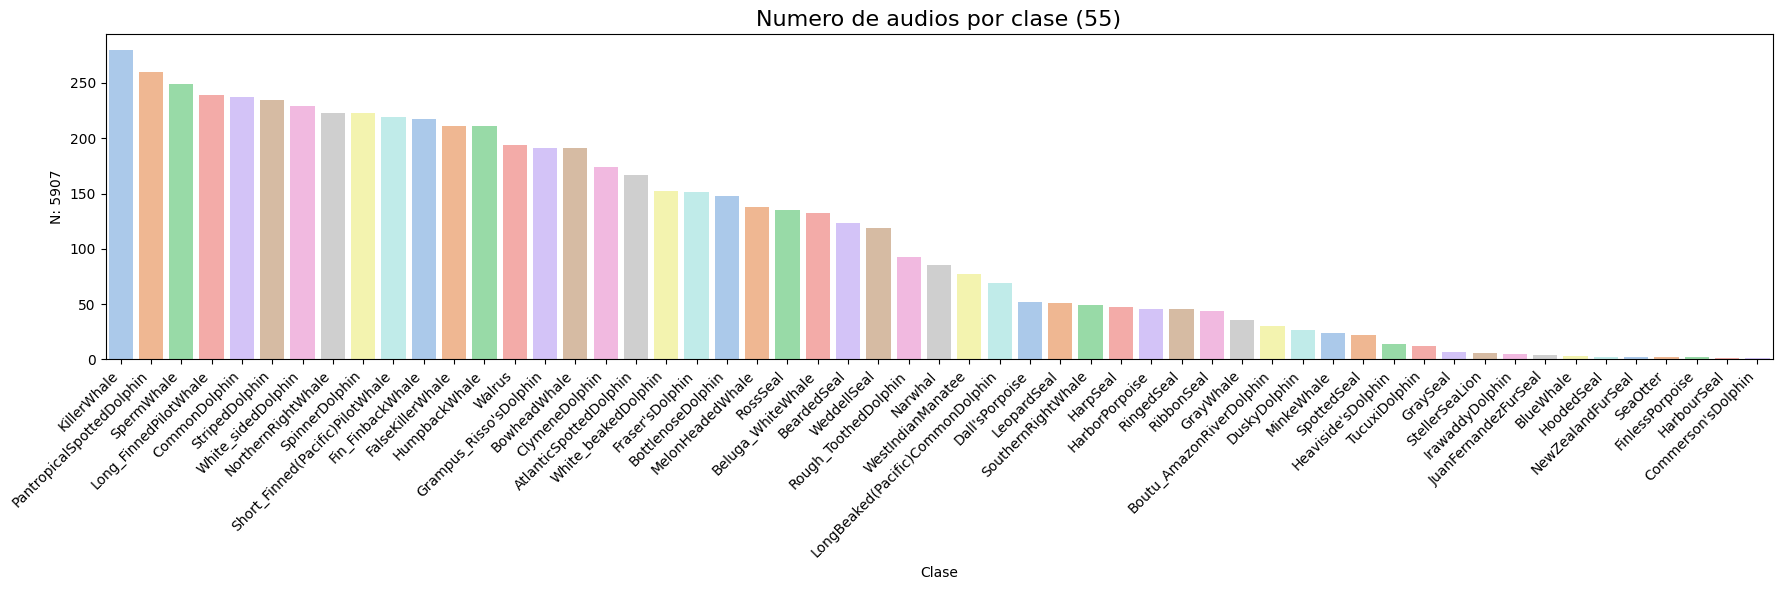

time: 947 ms (started: 2023-05-17 01:00:44 +00:00)


In [ ]:
# Nuevo data set con datos balanceados
fig = plt.figure(figsize=(18, 6))
sorted_class_ascend = df['class'].value_counts()
fig = sns.barplot(x=sorted_class_ascend.index, y=sorted_class_ascend.values, palette="pastel")
plt.xticks(rotation=45, ha="right")
plt.title(f"Numero de audios por clase ({len(set(df['class']))})", fontsize=16);
plt.ylabel(f'N: {df.shape[0]}')
plt.xlabel('Clase')
plt.tight_layout()

In [ ]:
# Balance de datos
# Crea un dataframe vacio para iteracion
df_for_dataset = pd.DataFrame(columns=['class', 'path', 'y'])
# Iteramos en cada una de las rutas
count = 1
for _ in range(len(df['path'])):
    # Elige una ruta y respectiva etiqueta de forma aletoria
    signal_path, label = get_rand_path(df)
    # Aumentacion de datos
    # Data_augment_freq_time es aleatoria en sus parametros
    # Puede tener errores en ciertas iteraciones
    # Por lo que se debe volver a correr cada vez que tenemos un error
    while True:
        try:
            audio_length = librosa.load(signal_path)[0].shape[0]
            if audio_length == 0:
                break
            y = data_augment_freq_time(signal_path)
        except Exception as e:
            print(f"Ocurrio un error: {str(e)} \nVolviendolo a intentar...N. {count}")
            continue
        else:
            count += 1
            break
    # Crea un df de una fila con la ruta y etiqueta elegida
    df_2 = pd.DataFrame({'class': [label],
                         'path': [signal_path],
                         'y': [y]})
    # Concatena o agrega dicha ruta al df vacio
    df_for_dataset = pd.concat([df_for_dataset, df_2], 
                               ignore_index=True)
# Crea un dict para codificar a entero las etiquetas
idx_label_dict = {label: i for i, label in enumerate(set(df_for_dataset['class']))}
# Define columna vacia al df iterado
df_for_dataset['label_encoded'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df_for_dataset['label_encoded'] = df_for_dataset['class'].map(lambda clase: idx_label_dict[clase])
# Codifica a one hot las etiquetas
one_hot_labels = tf.keras.utils.to_categorical(df_for_dataset['label_encoded'])
# Define una columana con las etiquetas codificadas en one hot
df_for_dataset['one_hot'] = one_hot_labels.tolist()
# Dataframe con clases balanceadas
dir = '/content/drive/MyDrive/Python/Deep learning/Proyecto/'
df_for_dataset.to_csv(dir+'df_for_dataset.csv', index=False)

Ocurrio un error: {{function_node __wrapped__RandomUniformInt_device_/job:localhost/replica:0/task:0/device:CPU:0}} Need minval < maxval, got 0 >= 0 [Op:RandomUniformInt] 
Volviendolo a intentar...N. 5
Ocurrio un error: {{function_node __wrapped__RandomUniformInt_device_/job:localhost/replica:0/task:0/device:CPU:0}} Need minval < maxval, got 0 >= -1 [Op:RandomUniformInt] 
Volviendolo a intentar...N. 6
Ocurrio un error: {{function_node __wrapped__RandomUniformInt_device_/job:localhost/replica:0/task:0/device:CPU:0}} Need minval < maxval, got 0 >= -4 [Op:RandomUniformInt] 
Volviendolo a intentar...N. 8
Ocurrio un error: {{function_node __wrapped__RandomUniformInt_device_/job:localhost/replica:0/task:0/device:CPU:0}} Need minval < maxval, got 0 >= -4 [Op:RandomUniformInt] 
Volviendolo a intentar...N. 8
Ocurrio un error: {{function_node __wrapped__RandomUniformInt_device_/job:localhost/replica:0/task:0/device:CPU:0}} Need minval < maxval, got 0 >= -6 [Op:RandomUniformInt] 
Volviendolo a in

In [ ]:
dir = '/content/drive/MyDrive/Python/Deep learning/Proyecto/'
df_for_dataset = pd.read_csv(os.path.join(dir,'df_for_dataset.csv'))
df_for_dataset

,class,path,y,label_encoded,one_hot
0,SpinnerDolphin,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 3.5703035905498837e-07, 1.23011341202072...",5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,Beluga_WhiteWhale,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 3.563128245787084e-07, 1.227481789101148...",52,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,RingedSeal,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 7.299726689780073e-08, 2.94810746481744e...",41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,HarborPorpoise,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, -1.9709753473762248e-07, 3.4199823062408...",53,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Heaviside'sDolphin,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
5902,Heaviside'sDolphin,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 5.060041530668968e-06, 7.489205927413423...",44,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5903,Heaviside'sDolphin,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 1.944290728417286e-09, 3.198612574806248...",44,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5904,Fraser'sDolphin,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 2.2051210635254392e-07, 8.76881529165984...",25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5905,PantropicalSpottedDolphin,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 5.0663500061887135e-09, 8.42825631508503...",9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
def try_except_literal_eval(y):
    """
    Esta es un wraper de la funcion:
    * ast.literal_eval
    Para el caso [nan, nan, ..., nan]
    """
    try:
        y = ast.literal_eval(y)
    except Exception as e:
        print(f"Ocurrio un error: {str(e)} \nEn el dato: {y}")
        y = [0] * y.count('nan')
    return y

In [ ]:
# Define columna vacia al df iterado
df_for_dataset['embedings'] = ''
# Rellena la columna vacia con las etiquetas codificadas
df_for_dataset['embedings'] = df_for_dataset['y'].map(lambda clase: extract_embedding(try_except_literal_eval(clase)).numpy().tolist()[0])
df_for_dataset

Ocurrio un error: malformed node or string on line 1: <ast.Name object at 0x7f5cf5ee88b0> 
En el dato: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, n

,class,path,y,label_encoded,one_hot,embedings
0,SpinnerDolphin,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 3.5703035905498837e-07, 1.23011341202072...",5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.14622068405151367, 0.0, 0.0, 0.0,..."
1,Beluga_WhiteWhale,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 3.563128245787084e-07, 1.227481789101148...",52,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00046813488006591797, 0.0, 0.0, 0.0, 0..."
2,RingedSeal,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 7.299726689780073e-08, 2.94810746481744e...",41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.009228494949638844, 0.06600812077..."
3,HarborPorpoise,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, -1.9709753473762248e-07, 3.4199823062408...",53,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.11851605027914047, 0.0, 0.0,..."
4,Heaviside'sDolphin,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
5902,Heaviside'sDolphin,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 5.060041530668968e-06, 7.489205927413423...",44,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.35288771986961365, 0.0, 0.0, 0.0,..."
5903,Heaviside'sDolphin,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 1.944290728417286e-09, 3.198612574806248...",44,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.11999513953924179, 0.255815625190..."
5904,Fraser'sDolphin,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 2.2051210635254392e-07, 8.76881529165984...",25,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0003265241684857756, 0.0, 0.0, 0.0, 0.00542..."
5905,PantropicalSpottedDolphin,/content/drive/MyDrive/Python/Deep learning/Pr...,"[0.0, 5.0663500061887135e-09, 8.42825631508503...",9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.3366267681121826, 0.9903591275215149, ..."


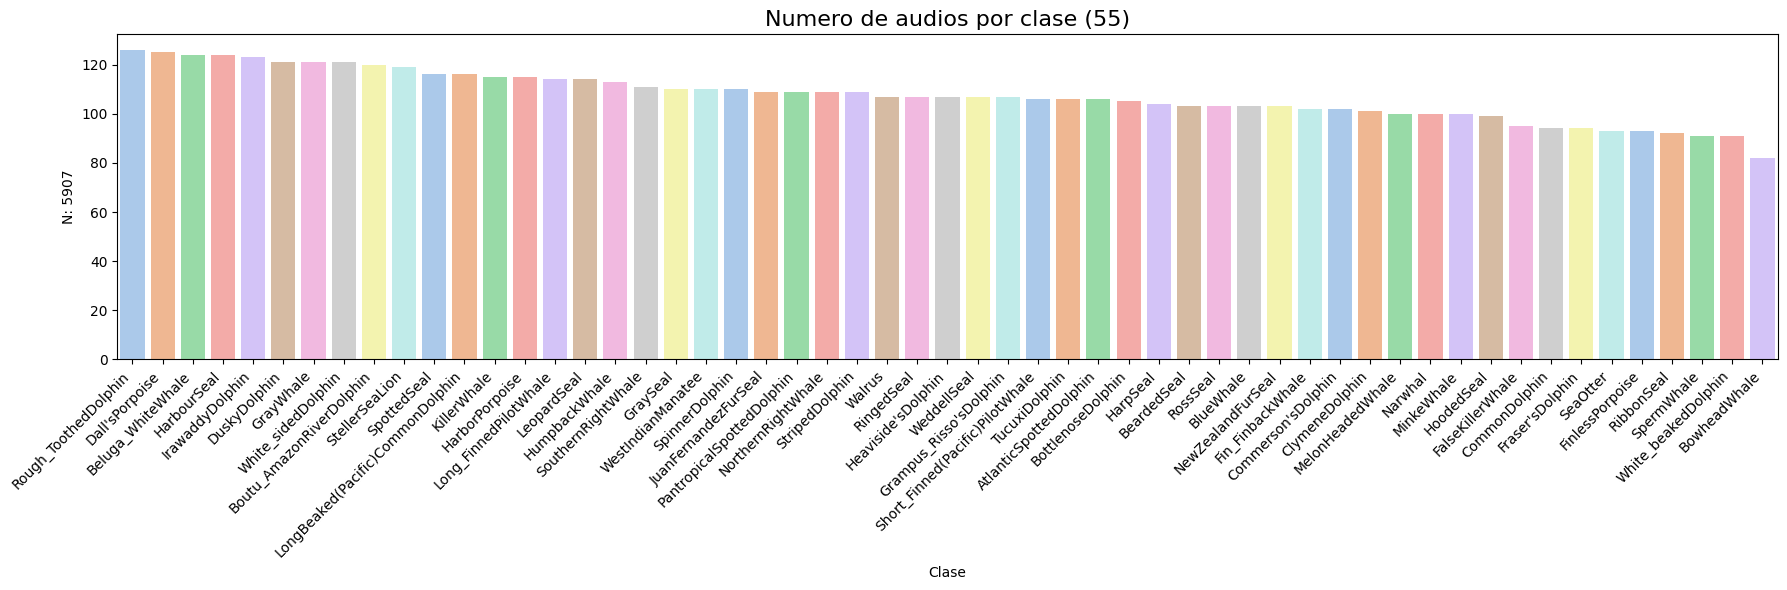

In [ ]:
# Nuevo data set con datos balanceados
fig = plt.figure(figsize=(18, 6))
sorted_class_ascend = df_for_dataset['class'].value_counts()
fig = sns.barplot(x=sorted_class_ascend.index, y=sorted_class_ascend.values, palette="pastel")
plt.xticks(rotation=45, ha="right")
plt.title(f"Numero de audios por clase ({len(set(df_for_dataset['class']))})", fontsize=16);
plt.ylabel(f'N: {df_for_dataset.shape[0]}')
plt.xlabel('Clase')
plt.tight_layout()

# **Entrenamiento y Validación**
---

Este notebook es una plantilla que le puede servir como guía para el cuarto entregable del proyecto aplicado.

In [ ]:
# Particion del conjunto de datos
from sklearn.model_selection import train_test_split
# Define conjuntos: train y test
X_train, X_test, y_train, y_test = train_test_split(np.array(df_for_dataset['embedings'].tolist()), 
                                                    np.array(df_for_dataset['label_encoded'].tolist()), 
                                                    test_size=0.1, 
                                                    random_state=42
                                                    )
print(f'X_train size: {X_train.shape} \ny_train size: {y_train.shape}')
print(f'X_test size: {X_test.shape} \ny_test size: {y_test.shape}')

X_train size: (5316, 1024) 
y_train size: (5316,)
X_test size: (591, 1024) 
y_test size: (591,)


In [ ]:
X_train

array([[0.        , 0.04334665, 0.38759354, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.05813566, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.49001908, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00362446, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
# Define el generador de datos
main_ds = tf.data.Dataset.from_tensor_slices((X_train, 
                                              y_train))

In [ ]:
data_label1 = iter(main_ds.take(1)).next()
data_label1

(<tf.Tensor: shape=(1024,), dtype=float64, numpy=
 array([0.        , 0.04334665, 0.38759354, ..., 0.        , 0.        ,
        0.        ])>,
 <tf.Tensor: shape=(), dtype=int64, numpy=12>)

In [ ]:
# Aleatoriza el orden de los datos de entrenamiento 
main_ds = main_ds.cache().shuffle(buffer_size=X_train.shape[0])
# Numero total de datos del subconjunto
num_examples = X_train.shape[0]
# Define los tamanos de los conjuntos de entreneminto y validacion
train_size = int(0.7 * num_examples)
val_size = int(0.3 * num_examples)
print(f'Train size: {train_size}, validation size: {val_size}')
# Divide los datos en conjuntos de: entrenamiento y validation
train_data = main_ds.cache().take(train_size).repeat()
val_data = main_ds.cache().skip(train_size).take(val_size).repeat()
# Define tamano del batch
batch_size = 64
# Define los batch para los conjuntos train y validation
train_data = train_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = val_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_data.element_spec

Train size: 3721, validation size: 1063


(TensorSpec(shape=(None, 1024), dtype=tf.float64, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

In [ ]:
# Ejemplo de 1 batch
# batch_1_train = iter(main_ds.take(1)).next()
batch_1_train = iter(train_data.take(1)).next()
batch_1_train

(<tf.Tensor: shape=(64, 1024), dtype=float64, numpy=
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.00172976, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.01990266, 0.        , ..., 0.        , 0.        ,
         0.        ]])>,
 <tf.Tensor: shape=(64,), dtype=int64, numpy=
 array([24, 53, 17, 10, 10, 17, 31,  8, 17, 22, 14, 26, 28, 17, 45,  2, 34,
        26, 35, 51, 11, 34, 18,  4,  5, 46, 53,  8,  0, 53, 10,  6, 42,  9,
        16, 24, 12, 53,  7, 29, 44, 43, 38, 39, 44, 47, 40,  0, 54, 16, 24,
        31, 10,  3,  8,  0, 23,  4, 45, 13, 47, 19, 12,  8])>)

In [ ]:
# Ejemplo de 1 batch
batch_1_val = iter(val_data.take(1)).next()
batch_1_val

(<tf.Tensor: shape=(64, 1024), dtype=float64, numpy=
 array([[0.        , 0.        , 0.14192921, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02754961, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.02511895, ..., 0.        , 0.        ,
         0.        ],
        [0.01243859, 0.        , 0.0300883 , ..., 0.23467784, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])>,
 <tf.Tensor: shape=(64,), dtype=int64, numpy=
 array([38,  3, 54, 47, 54, 53, 50, 25, 24, 29, 49, 49, 32, 54,  3, 19, 29,
         6,  3, 51, 35, 44,  9, 12, 44, 32, 45, 47, 45, 46, 52,  9, 37,  2,
        45, 34, 41,  9, 37, 28, 11, 10,  1, 25, 11, 35, 47, 19, 49, 27, 21,
        40, 14, 38, 34, 41, 20,  2, 32, 51, 48,  3, 26, 28])>)

## **1. Entrenamiento del Modelo y Selección de Hiperparámetros**
---

Si está utilizando un modelo que requiere entrenamiento, deberá entrenarlo y seleccionar un conjunto de hiperparámetros válido para el mismo. Recuerde que tiene diversas herramientas para hacer validación.

In [ ]:
# ---**INGRESE SU CÓDIGO**---

In [ ]:
# Define la parte superior del modelo para Calentamiento (Warming Up)
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(df_for_dataset['class'])))
    ], name='my_model')
# Resumen de las capas superiores de salida
my_model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 55)                28215     
                                                                 
Total params: 553,015
Trainable params: 553,015
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compilacion: define funcion de perdida y optimizador
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer=tf.optimizers.Adam(learning_rate=1e-3),
                 metrics=['accuracy'])
# Define Callbacks para monitores de la perdida en validacion
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='val_checkpoint.h5', 
                                                      monitor="val_loss", 
                                                      verbose=True, 
                                                      save_best_only=True,
                                                      save_weights_only=True, 
                                                      mode="min")
stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=50,
                                            mode="min",
                                            restore_best_weights=True)
callbacks = [checkpoint, stopping]

In [ ]:
# Entrenamiento numero: 1
# Calcula el numero de steps_per_epoch
steps_per_epoch = train_size // batch_size 
# Calcula el numero de validation steps
validation_steps = val_size // batch_size
# Entrena las capas superiores
history = my_model.fit(train_data,
                       epochs= 100,
                       steps_per_epoch = steps_per_epoch,
                       validation_data = val_data,
                       validation_steps = validation_steps,
                       callbacks = callbacks)


Epoch 1/100
54/58 [==========================>...] - ETA: 0s - loss: 3.8310 - accuracy: 0.0891
Epoch 1: val_loss improved from inf to 3.45436, saving model to val_checkpoint.h5
58/58 [==============================] - 2s 16ms/step - loss: 3.8131 - accuracy: 0.0908 - val_loss: 3.4544 - val_accuracy: 0.1279
Epoch 2/100
58/58 [==============================] - ETA: 0s - loss: 3.2845 - accuracy: 0.1689
Epoch 2: val_loss improved from 3.45436 to 3.11730, saving model to val_checkpoint.h5
58/58 [==============================] - 1s 12ms/step - loss: 3.2845 - accuracy: 0.1689 - val_loss: 3.1173 - val_accuracy: 0.2070
Epoch 3/100
53/58 [==========================>...] - ETA: 0s - loss: 2.9998 - accuracy: 0.2099
Epoch 3: val_loss improved from 3.11730 to 2.88670, saving model to val_checkpoint.h5
58/58 [==============================] - 1s 12ms/step - loss: 2.9934 - accuracy: 0.2112 - val_loss: 2.8867 - val_accuracy: 0.2266
Epoch 4/100
58/58 [==============================] - ETA: 0s - loss: 2.

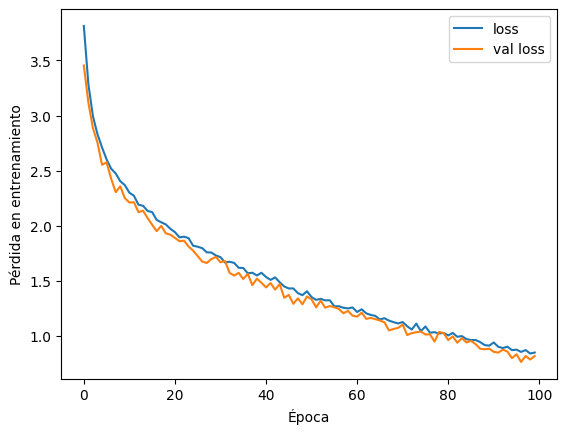

In [ ]:
# Entrenamiento numero: 1
# Entrenamiento de las capas superiores del modelo
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val loss')
plt.xlabel("Época"); plt.ylabel("Pérdida en entrenamiento")
plt.legend()

In [ ]:
# Entrenamiento numero: 2
# Calcula el numero de steps_per_epoch
steps_per_epoch = train_size // batch_size 
# Calcula el numero de validation steps
validation_steps = val_size // batch_size
# Entrena las capas superiores
history = my_model.fit(train_data,
                       epochs= 100,
                       steps_per_epoch = steps_per_epoch,
                       validation_data = val_data,
                       validation_steps = validation_steps,
                       callbacks = callbacks)

Epoch 1/100
57/58 [============================>.] - ETA: 0s - loss: 0.8133 - accuracy: 0.7618
Epoch 1: val_loss did not improve from 0.76391
58/58 [==============================] - 1s 22ms/step - loss: 0.8140 - accuracy: 0.7608 - val_loss: 0.7687 - val_accuracy: 0.7695
Epoch 2/100
57/58 [============================>.] - ETA: 0s - loss: 0.8422 - accuracy: 0.7453
Epoch 2: val_loss did not improve from 0.76391
58/58 [==============================] - 1s 25ms/step - loss: 0.8402 - accuracy: 0.7468 - val_loss: 0.7911 - val_accuracy: 0.7871
Epoch 3/100
58/58 [==============================] - ETA: 0s - loss: 0.8006 - accuracy: 0.7570
Epoch 3: val_loss did not improve from 0.76391
58/58 [==============================] - 1s 23ms/step - loss: 0.8006 - accuracy: 0.7570 - val_loss: 0.8129 - val_accuracy: 0.7666
Epoch 4/100
54/58 [==========================>...] - ETA: 0s - loss: 0.8004 - accuracy: 0.7627
Epoch 4: val_loss improved from 0.76391 to 0.74483, saving model to val_checkpoint.h5
58/

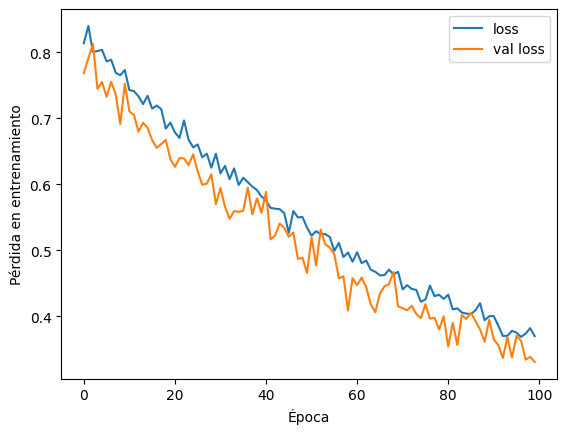

In [ ]:
# Entrenamiento numero: 2
# Entrenamiento de las capas superiores del modelo
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val loss')
plt.xlabel("Época"); plt.ylabel("Pérdida en entrenamiento")
plt.legend()

In [ ]:
# Entrenamiento numero: 3
# Calcula el numero de steps_per_epoch
steps_per_epoch = train_size // batch_size 
# Calcula el numero de validation steps
validation_steps = val_size // batch_size
# Entrena las capas superiores
history = my_model.fit(train_data,
                       epochs= 100,
                       steps_per_epoch = steps_per_epoch,
                       validation_data = val_data,
                       validation_steps = validation_steps,
                       callbacks = callbacks)

Epoch 1/100
58/58 [==============================] - ETA: 0s - loss: 0.3650 - accuracy: 0.8982
Epoch 1: val_loss did not improve from 0.33107
58/58 [==============================] - 1s 25ms/step - loss: 0.3650 - accuracy: 0.8982 - val_loss: 0.3533 - val_accuracy: 0.9131
Epoch 2/100
55/58 [===========================>..] - ETA: 0s - loss: 0.3719 - accuracy: 0.8997
Epoch 2: val_loss did not improve from 0.33107
58/58 [==============================] - 1s 12ms/step - loss: 0.3724 - accuracy: 0.9001 - val_loss: 0.3386 - val_accuracy: 0.9092
Epoch 3/100
58/58 [==============================] - ETA: 0s - loss: 0.3781 - accuracy: 0.8914
Epoch 3: val_loss did not improve from 0.33107
58/58 [==============================] - 1s 11ms/step - loss: 0.3781 - accuracy: 0.8914 - val_loss: 0.3465 - val_accuracy: 0.9102
Epoch 4/100
54/58 [==========================>...] - ETA: 0s - loss: 0.3501 - accuracy: 0.9083
Epoch 4: val_loss improved from 0.33107 to 0.30478, saving model to val_checkpoint.h5
58/

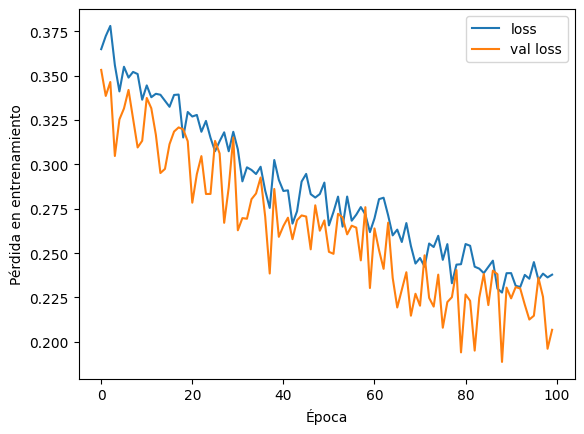

In [ ]:
# Entrenamiento numero: 3
# Entrenamiento de las capas superiores del modelo
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val loss')
plt.xlabel("Época"); plt.ylabel("Pérdida en entrenamiento")
plt.legend()

In [ ]:
# Entrenamiento numero: 4
# Calcula el numero de steps_per_epoch
steps_per_epoch = train_size // batch_size 
# Calcula el numero de validation steps
validation_steps = val_size // batch_size
# Entrena las capas superiores
history = my_model.fit(train_data,
                       epochs= 100,
                       steps_per_epoch = steps_per_epoch,
                       validation_data = val_data,
                       validation_steps = validation_steps,
                       callbacks = callbacks)

Epoch 1/100
58/58 [==============================] - ETA: 0s - loss: 0.2339 - accuracy: 0.9305
Epoch 1: val_loss did not improve from 0.18866
58/58 [==============================] - 1s 12ms/step - loss: 0.2339 - accuracy: 0.9305 - val_loss: 0.2216 - val_accuracy: 0.9316
Epoch 2/100
58/58 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9388
Epoch 2: val_loss improved from 0.18866 to 0.18055, saving model to val_checkpoint.h5
58/58 [==============================] - 1s 12ms/step - loss: 0.2200 - accuracy: 0.9388 - val_loss: 0.1805 - val_accuracy: 0.9551
Epoch 3/100
54/58 [==========================>...] - ETA: 0s - loss: 0.2274 - accuracy: 0.9346
Epoch 3: val_loss did not improve from 0.18055
58/58 [==============================] - 1s 12ms/step - loss: 0.2293 - accuracy: 0.9337 - val_loss: 0.1925 - val_accuracy: 0.9414
Epoch 4/100
53/58 [==========================>...] - ETA: 0s - loss: 0.2216 - accuracy: 0.9393
Epoch 4: val_loss did not improve from 0.18055
58/

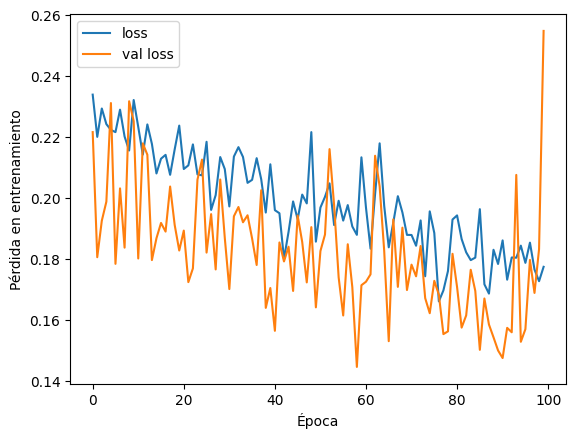

In [ ]:
# Entrenamiento numero: 4
# Entrenamiento de las capas superiores del modelo
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val loss')
plt.xlabel("Época"); plt.ylabel("Pérdida en entrenamiento")
plt.legend()

In [ ]:
# Entrenamiento numero: 5
# Calcula el numero de steps_per_epoch
steps_per_epoch = train_size // batch_size 
# Calcula el numero de validation steps
validation_steps = val_size // batch_size
# Entrena las capas superiores
history = my_model.fit(train_data,
                       epochs= 100,
                       steps_per_epoch = steps_per_epoch,
                       validation_data = val_data,
                       validation_steps = validation_steps,
                       callbacks = callbacks)

Epoch 1/100
56/58 [===========================>..] - ETA: 0s - loss: 0.1796 - accuracy: 0.9456
Epoch 1: val_loss did not improve from 0.14456
58/58 [==============================] - 1s 18ms/step - loss: 0.1787 - accuracy: 0.9453 - val_loss: 0.1601 - val_accuracy: 0.9541
Epoch 2/100
58/58 [==============================] - ETA: 0s - loss: 0.1977 - accuracy: 0.9380
Epoch 2: val_loss improved from 0.14456 to 0.14333, saving model to val_checkpoint.h5
58/58 [==============================] - 1s 18ms/step - loss: 0.1977 - accuracy: 0.9380 - val_loss: 0.1433 - val_accuracy: 0.9561
Epoch 3/100
58/58 [==============================] - ETA: 0s - loss: 0.1821 - accuracy: 0.9418
Epoch 3: val_loss improved from 0.14333 to 0.13675, saving model to val_checkpoint.h5
58/58 [==============================] - 1s 18ms/step - loss: 0.1821 - accuracy: 0.9418 - val_loss: 0.1367 - val_accuracy: 0.9629
Epoch 4/100
57/58 [============================>.] - ETA: 0s - loss: 0.1675 - accuracy: 0.9463
Epoch 4: va

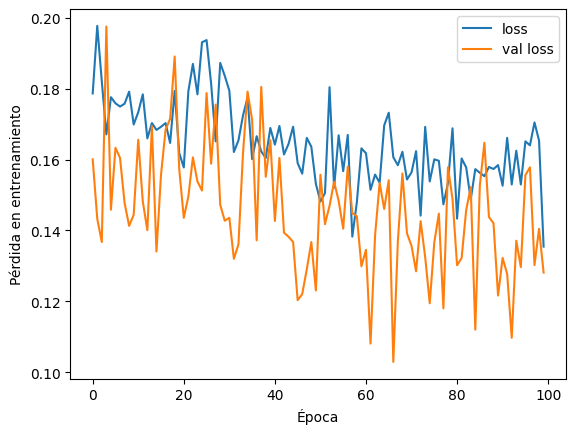

In [ ]:
# Entrenamiento numero: 5
# Entrenamiento de las capas superiores del modelo
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val loss')
plt.xlabel("Época"); plt.ylabel("Pérdida en entrenamiento")
plt.legend()

In [ ]:
# Entrenamiento numero: 6
# Calcula el numero de steps_per_epoch
steps_per_epoch = train_size // batch_size 
# Calcula el numero de validation steps
validation_steps = val_size // batch_size
# Entrena las capas superiores
history = my_model.fit(train_data,
                       epochs= 100,
                       steps_per_epoch = steps_per_epoch,
                       validation_data = val_data,
                       validation_steps = validation_steps,
                       callbacks = callbacks)

Epoch 1/100
55/58 [===========================>..] - ETA: 0s - loss: 0.1504 - accuracy: 0.9540
Epoch 1: val_loss did not improve from 0.10291
58/58 [==============================] - 1s 11ms/step - loss: 0.1558 - accuracy: 0.9518 - val_loss: 0.1391 - val_accuracy: 0.9482
Epoch 2/100
58/58 [==============================] - ETA: 0s - loss: 0.1550 - accuracy: 0.9523
Epoch 2: val_loss did not improve from 0.10291
58/58 [==============================] - 1s 11ms/step - loss: 0.1550 - accuracy: 0.9523 - val_loss: 0.1372 - val_accuracy: 0.9580
Epoch 3/100
58/58 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9464
Epoch 3: val_loss did not improve from 0.10291
58/58 [==============================] - 1s 11ms/step - loss: 0.1642 - accuracy: 0.9464 - val_loss: 0.1472 - val_accuracy: 0.9551
Epoch 4/100
57/58 [============================>.] - ETA: 0s - loss: 0.1516 - accuracy: 0.9501
Epoch 4: val_loss did not improve from 0.10291
58/58 [==============================] - 1

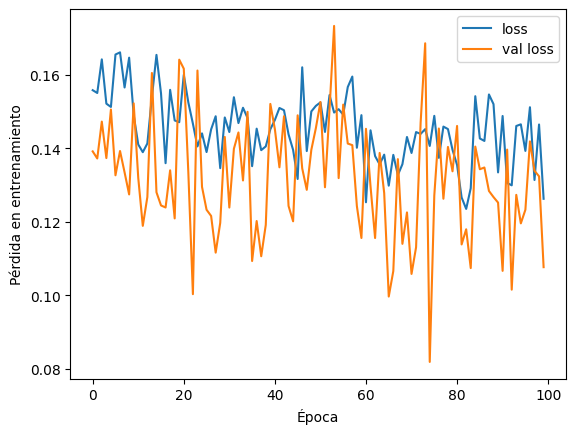

In [ ]:
# Entrenamiento numero: 6
# Entrenamiento de las capas superiores del modelo
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val loss')
plt.xlabel("Época"); plt.ylabel("Pérdida en entrenamiento")
plt.legend()

## **2. Evaluación o Aplicación del modelo**
---

Si entrenó un modelo, recuerde que debe reportar el desempeño del mismo sobre un conjunto de datos no visto (test). Considere que dispone de las siguientes métricas:

- **Clasificación**: accuracy, precision, recall, f1-score, AUC.
- **Regresión**: $r^2$, error cuadrático medio, error absoluto medio.
- **Agrupamiento**: coeficiente de silueta, índice de Davies-Bouldin.

In [ ]:
# ---**INGRESE SU CÓDIGO**---

In [ ]:
# Predice los logits utilizando el modelo `my_model` en los datos de prueba `X_test`
pred_logits = my_model.predict(X_test)
# Aplica la función de softmax a los logits para obtener probabilidades normalizadas
pred_prop = tf.nn.softmax(pred_logits)
# Codifica las etiquetas predichas al encontrar el índice del valor máximo a lo largo del eje 1
pred_label_encode = tf.argmax(pred_prop, axis=1)

19/19 [==============================] - 0s 4ms/step


In [ ]:
# Importa todas las métricas de sklearn
from sklearn.metrics import *
# Imprime el informe de clasificación 
# Comparando las etiquetas reales (y_test) con las etiquetas predichas (pred_label_encode)flip_idx_label_dict = {value: key for key, value in idx_label_dict.items()}
print(classification_report(y_test, pred_label_encode))

              precision    recall  f1-score   support

           0       0.23      0.23      0.23        13
           1       0.17      0.18      0.17        11
           2       0.38      0.25      0.30        12
           3       0.33      0.25      0.29         8
           4       0.22      0.22      0.22         9
           5       0.29      0.31      0.30        13
           6       0.10      0.10      0.10        10
           7       0.11      0.17      0.13         6
           8       0.20      0.22      0.21         9
           9       0.11      0.12      0.12         8
          10       0.43      0.43      0.43         7
          11       0.20      0.22      0.21         9
          12       0.00      0.00      0.00         8
          13       0.50      0.31      0.38        13
          14       0.39      0.78      0.52         9
          15       0.57      0.24      0.33        17
          16       0.17      0.22      0.19         9
          17       0.90    

Adicionalmente, si utilizó un modelo pre-entrenado, debe generar predicciones y mostrar el resultado final de la aplicación del modelo sobre sus datos:

In [ ]:
# ---**INGRESE SU CÓDIGO**---

In [ ]:
# Definimos el directorio base
dir = './content/data/'
# Optenemos una lista de las rutas locales de cada audio
list_paths = get_list_path_from_subfolders(dir)
# Crea un df con dos columans clases y rutas
df_aplica =  get_df_labels_paths(list_paths)
# Elige una clase y una ruta aleatoria
signal_path, label = get_rand_path(df_aplica)
# Convierte la senal en array
signal_original, sr = librosa.load(signal_path)
# Embeding de la senal
extract_embedding(signal_original)
# Diccionario para codificar y decodificar las etiquetas
idx_label_dict = {label: i for i, label in enumerate(set(df_for_dataset['class']))}
flip_idx_label_dict = {value: key for key, value in idx_label_dict.items()}
# Predice los logits utilizando el modelo `my_model` en los datos de prueba `X_test`
pred_logits = my_model.predict(extract_embedding(signal_original))
# Aplica la función de softmax a los logits para obtener probabilidades normalizadas
pred_label_encode = pred_logits.mean(axis=0).argmax()
# Comparacion entre la clase real y la predicha
print(f"Original: {label} vs. Predicha: {flip_idx_label_dict[pred_label_encode]}")
ipd.Audio(signal_original, rate=sr)

1/1 [==============================] - 0s 39ms/step
Original: SeaOtter vs. Predicha: SeaOtter


# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes :**
  * [Santiago Toledo Cortés](https://sites.google.com/unal.edu.co/santiagotoledo-cortes/) 
* **Diseño de imágenes:**
    - [Mario Andres Rodriguez Triana](mailto:mrodrigueztr@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*